# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Load and Preprocess dataset

In [2]:
df = pd.read_csv('Biotech_preprocessed_dataset_with_outliers.csv')
df['Time'] = pd.to_datetime(df['Time'])
df['Date'] = df['Time'].dt.date
df.set_index('Date', inplace=True)
df

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-03-01,2024-03-01 00:00:00,0:00:00,0,Friday,792,410,198,184,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 01:00:00,1:00:00,1,Friday,733,222,326,185,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 02:00:00,2:00:00,2,Friday,706,222,300,184,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 03:00:00,3:00:00,3,Friday,684,302,197,185,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 04:00:00,4:00:00,4,Friday,784,400,199,185,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,2024-05-31 19:00:00,19:00:00,19,Friday,1070,702,194,174,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 20:00:00,20:00:00,20,Friday,689,212,295,182,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 21:00:00,21:00:00,21,Friday,718,213,322,183,True,False,False,False,False,False,False,False


In [3]:
df.describe()

,Time,Hour,Total (W),Phase_A (W),Phase_B (W),Phase_C (W)
count,2208,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,2024-04-15 23:30:00,11.500000,1174.199728,643.772192,343.756341,186.619112
min,2024-03-01 00:00:00,0.000000,371.000000,76.000000,109.000000,92.000000
25%,2024-03-23 23:45:00,5.750000,757.750000,316.750000,210.000000,116.000000
50%,2024-04-15 23:30:00,11.500000,958.500000,455.000000,294.000000,183.000000
75%,2024-05-08 23:15:00,17.250000,1302.250000,780.250000,363.000000,186.000000
max,2024-05-31 23:00:00,23.000000,6818.000000,6390.000000,2248.000000,3682.000000
std,NaN,6.923755,792.425590,653.310162,233.842126,126.651852


In [4]:
df_holiday = df[df['Holiday'] == True]
df_holiday

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-03-02,2024-03-02 00:00:00,0:00:00,0,Saturday,755,187,384,184,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 01:00:00,1:00:00,1,Saturday,620,232,203,185,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 02:00:00,2:00:00,2,Saturday,800,307,309,184,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 03:00:00,3:00:00,3,Saturday,801,418,199,184,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 04:00:00,4:00:00,4,Saturday,710,330,196,184,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,2024-05-28 19:00:00,19:00:00,19,Tuesday,1368,902,284,182,False,False,False,False,False,True,False,True
2024-05-28,2024-05-28 20:00:00,20:00:00,20,Tuesday,1533,1051,299,183,False,False,False,False,False,True,False,True
2024-05-28,2024-05-28 21:00:00,21:00:00,21,Tuesday,899,395,321,183,False,False,False,False,False,True,False,True


In [5]:
df_office_day = df[df['Holiday'] == False]
df_office_day

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-03-01,2024-03-01 00:00:00,0:00:00,0,Friday,792,410,198,184,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 01:00:00,1:00:00,1,Friday,733,222,326,185,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 02:00:00,2:00:00,2,Friday,706,222,300,184,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 03:00:00,3:00:00,3,Friday,684,302,197,185,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 04:00:00,4:00:00,4,Friday,784,400,199,185,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,2024-05-31 19:00:00,19:00:00,19,Friday,1070,702,194,174,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 20:00:00,20:00:00,20,Friday,689,212,295,182,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 21:00:00,21:00:00,21,Friday,718,213,322,183,True,False,False,False,False,False,False,False


<Axes: xlabel='Date'>

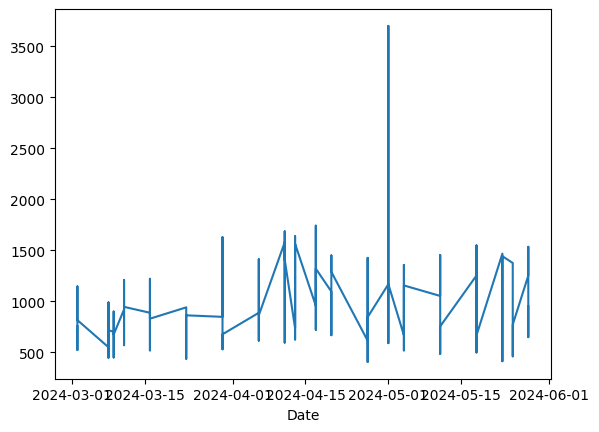

In [6]:
df_holiday['Total (W)'].plot()

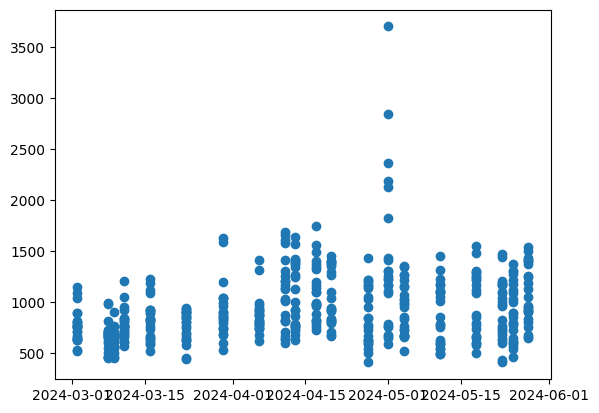

In [7]:
plt.scatter(df_holiday.index, df_holiday['Total (W)'])
plt.show()

<Axes: xlabel='Date'>

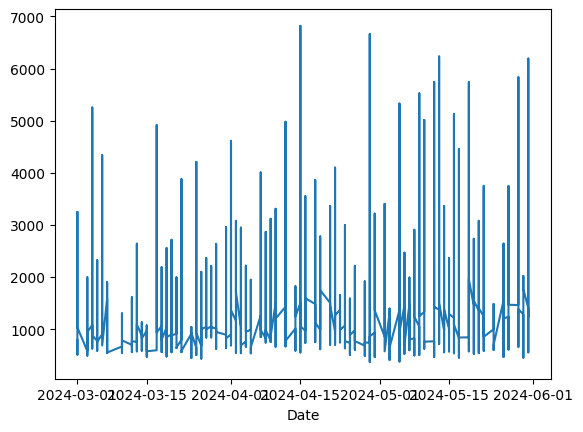

In [8]:
df_office_day['Total (W)'].plot()

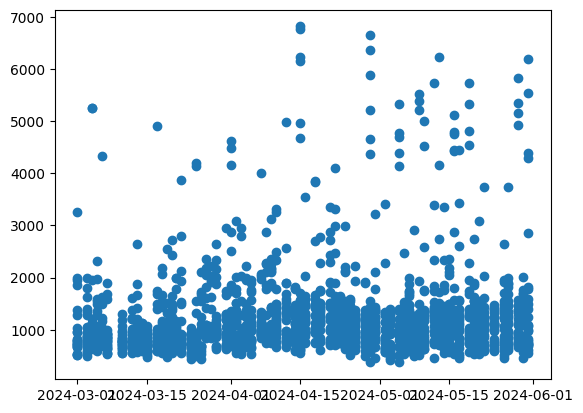

In [9]:
plt.scatter(df_office_day.index, df_office_day['Total (W)'])
plt.show()

In [10]:
print(df_holiday['Total (W)'].mean())
print(df_office_day['Total (W)'].mean())

919.8145833333333
1244.8622685185185


**Drop Unnecessary columns** \
We are going to forecast total load based only on the previous values of total load. So, we wiil keep only the 'Total (W)' column.

In [11]:
df_office_day = pd.DataFrame(df_office_day['Total (W)'])
df_office_day

,Total (W)
Date,
2024-03-01,792
2024-03-01,733
2024-03-01,706
2024-03-01,684
2024-03-01,784
...,...
2024-05-31,1070
2024-05-31,689
2024-05-31,718


In [12]:
df_holiday = pd.DataFrame(df_holiday['Total (W)'])
df_holiday

,Total (W)
Date,
2024-03-02,755
2024-03-02,620
2024-03-02,800
2024-03-02,801
2024-03-02,710
...,...
2024-05-28,1368
2024-05-28,1533
2024-05-28,899


**Separate train and test data**

In [13]:
training_data_len = int(len(df_office_day)*0.8)
print(training_data_len)

train_data = df_office_day[:training_data_len]
test_data = df_office_day[training_data_len:]

print(train_data.shape, test_data.shape)

1382
(1382, 1) (346, 1)


In [14]:
print(train_data['Total (W)'].mean())
print(test_data['Total (W)'].mean())

1210.7503617945008
1381.112716763006


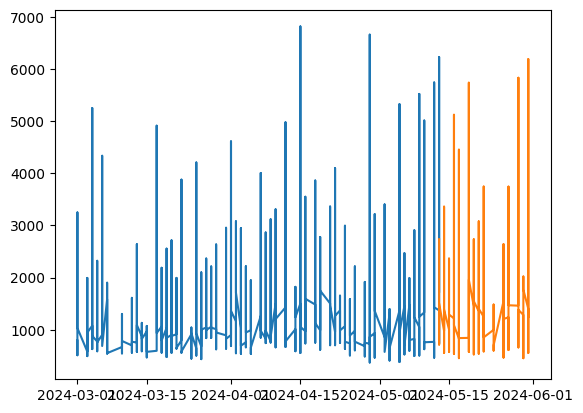

In [15]:
plt.plot(train_data['Total (W)'])
plt.plot(test_data['Total (W)'])
plt.show()

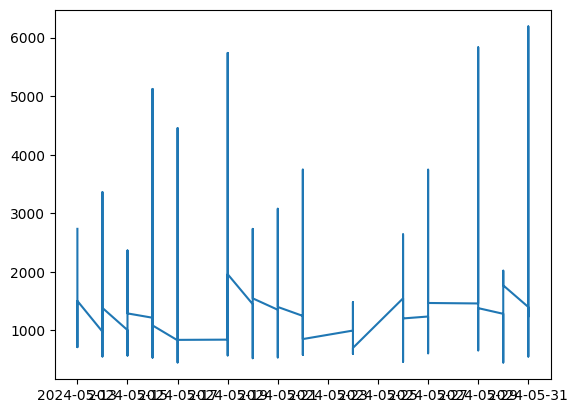

In [16]:
plt.plot(test_data['Total (W)'])
plt.show()

In [17]:
dataset_train = train_data['Total (W)'].values
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape


(1382, 1)

In [18]:
dataset_test = test_data['Total (W)'].values
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(346, 1)

**Scaling**

In [19]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_train[:5])
print(scaled_test[:5])

[[-0.86939662]
 [-0.88769971]
 [-0.89607569]
 [-0.90290057]
 [-0.87187839]]
[[-0.20460091]
 [-0.6918787 ]
 [-0.8358313 ]
 [-0.78529104]
 [-0.7309167 ]]


**Create Sequences**

In [20]:
sequence_length = 24
X_train, y_train = [], []
for i in range(len(scaled_train)-sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((1358, 24, 1), (1358, 24, 1))

In [21]:
X_test, y_test = [], []
for i in range(len(scaled_test)-sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)


**Convert to Tensors**

In [22]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([1358, 24, 1]) torch.Size([1358, 24, 1])
torch.Size([322, 24, 1]) torch.Size([322, 24, 1])


# Create Model

In [48]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out)
    return out


In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [50]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

model = LSTM(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


**Torch Dataloader**

In [51]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [52]:
for x, y in train_loader:
	print(f'X shape: {x.shape}, y shape: {y.shape}')
	break

X shape: torch.Size([32, 24, 1]), y shape: torch.Size([32, 24, 1])


# Train the Model

In [53]:
num_epochs = 20
train_loss_hist =[]
test_loss_hist =[]
train_mape_hist = []
test_mape_hist = []
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0
	total_mape = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()
		total_mape += torch.mean(torch.abs((predictions - batch_y)/(batch_y+1e-8))*100.0)

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_loss_hist.append(average_loss)
	average_mape = total_mape / len(train_loader)
	train_mape_hist.append(average_mape)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0
		total_test_mape = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_mape += torch.mean(torch.abs((predictions_test - batch_y_test)/(batch_y_test+1e-8))*100.0)
			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_loss_hist.append(average_test_loss)
		average_test_mape = total_test_mape / len(test_loader)
		test_mape_hist.append(average_test_mape)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/20] - Training Loss: 0.0419, Test Loss: 0.0801
Epoch [20/20] - Training Loss: 0.0397, Test Loss: 0.0780


In [54]:
for i in range(len(train_mape_hist)):
  if (i+1) % 10 == 0:
    print(f'Epoch {i+1} - Training MAPE: {train_mape_hist[i]:.2f}, Test MAPE: {test_mape_hist[i]:.2f}')

Epoch 10 - Training MAPE: 30.65, Test MAPE: 49.77
Epoch 20 - Training MAPE: 29.89, Test MAPE: 49.39


In [55]:
train_mapes = []
for i in range(len(train_mape_hist)):
  train_mapes.append(train_mape_hist[i].item())

test_mapes = []
for i in range(len(test_mape_hist)):
  test_mapes.append(test_mape_hist[i].item())

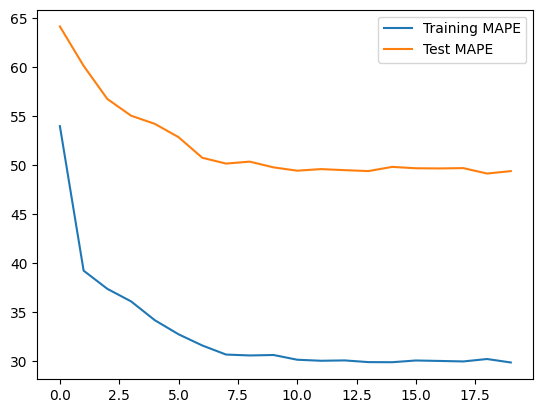

In [56]:
plt.plot(train_mapes, label="Training MAPE")
plt.plot(test_mapes, label="Test MAPE")
plt.legend()
plt.show()

# Plots

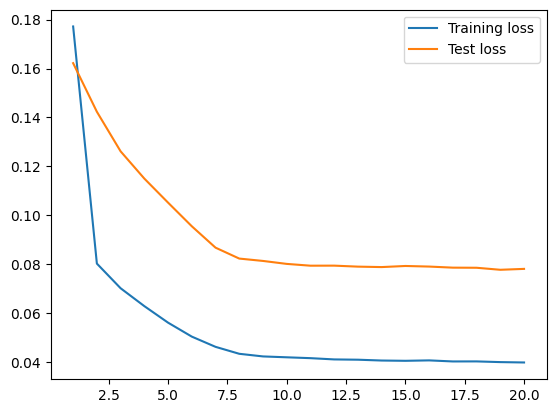

In [57]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_loss_hist,scalex=True, label="Training loss")
plt.plot(x, test_loss_hist, label="Test loss")
plt.legend()
plt.show()
